### Анализ xG статистики команд для расчета вероятности результата футбольного матча (Португальская лига)

## Теория
Ожидаемое количество голов (xG) — это показатель, предназначенный для измерения вероятности того, что удар приведет к голу.

Модель xG использует историческую информацию о значительном числе ударов по воротам с аналогичными характеристиками для оценки вероятности гола по шкале от 0 до 1.

Например, удар по воротам со значением xG 0,2 — это тот, который, как мы обычно ожидаем, будет реализован дважды за каждые 10 попыток».

## Загрузка исходных данных

Будущая модель будет базироваться на статистике Португальской лиги сезона 2022-2023, загружаем результаты всех проведенных игр и организуем таблицу так, чтобы систематизировать ключевые параметры:
- Домашняя команда (Home)
- Гостевая команда (Away)
- Ожидаемые голы Домашней команды (xGHome)
- Ожидаемые голы Гостевой команды (xGAway)

Данные тянем с сайта fbref.com

In [14]:
import pandas as pd

pd.set_option('display.max_rows', 1000)

url = 'https://fbref.com/en/comps/32/schedule/Primeira-Liga-Scores-and-Fixtures'

Portugal_Premier_list = []

Portugal_Premier_list.append(pd.read_html(url, index_col=False, flavor='lxml')[0])
Portugal_Premier_list = pd.concat(Portugal_Premier_list, axis=0, ignore_index=True)

Portugal_Premier_df = Portugal_Premier_list[Portugal_Premier_list['Wk'].notna()]

Portugal_Premier_df = Portugal_Premier_df.rename(columns={'xG':'xGHome', 'xG.1':'xGAway'})

Portugal_Premier_df['HomeScore'] = Portugal_Premier_df['Score'].str[0]
Portugal_Premier_df['AwayScore'] = Portugal_Premier_df['Score'].str[2]

Portugal_Premier_df = Portugal_Premier_df.drop(['Match Report','Notes'],axis=1)

# convert to date

Portugal_Premier_df['Date'] = pd.to_datetime(Portugal_Premier_df['Date'])

Portugal_Premier_df.sort_values(by='Date', inplace=True)

Portugal_Premier_df = Portugal_Premier_df[['Wk','Day','Date','Time','Home','HomeScore','xGHome','AwayScore','xGAway','Away','Attendance','Venue','Referee']]

In [2]:
Portugal_Premier_df = Portugal_Premier_df.dropna()
Portugal_Premier_df = Portugal_Premier_df[['Date','Home','HomeScore','xGHome','AwayScore','xGAway','Away']].reset_index(drop=True)

## Расчет среднего показателя xG Лиги для Домашней и Гостевой команд

In [3]:
league_Mean_Home_xG = round((Portugal_Premier_df['xGHome'].mean()),2)
league_Mean_Away_xG = round((Portugal_Premier_df['xGAway'].mean()),2)

### Home offense rating

Расчет атакующего рейтинга Домашней команды по формуле:

средний (xG в Домашней игре) каждой команды делим на средний показатель (xG в Домашней игре) по лиге

Формирование обновленной таблицы на основе расчета

In [4]:
home_team_xg_strength_offense = Portugal_Premier_df.groupby('Home').agg({'xGHome': 'sum', 'Home': ['count', 'first']})

home_team_xg_strength_offense.columns = ['xGHome', 'TotalGames', 'Home']

home_team_xg_strength_offense['xGHome_offense_rating'] = (home_team_xg_strength_offense['xGHome'] / home_team_xg_strength_offense['TotalGames']) / league_Mean_Home_xG
home_team_xg_strength_offense = home_team_xg_strength_offense.reset_index(drop = True)
home_team_xg_strength_offense = pd.DataFrame(home_team_xg_strength_offense)
home_team_xg_strength_offense.columns = ['xGHome', 'TotalGames','Home','xGHome_offense_rating']
home_team_xg_strength_offense = home_team_xg_strength_offense[['Home','xGHome','TotalGames','xGHome_offense_rating']]
home_team_xg_strength_offense.sort_values('xGHome_offense_rating', ascending=False)

,Home,xGHome,TotalGames,xGHome_offense_rating
1,Benfica,36.3,11,2.229730
12,Porto,27.3,10,1.844595
15,Sporting CP,22.8,10,1.540541
3,Braga,17.0,10,1.148649
17,Vizela,17.4,11,1.068796
11,Portimonense,17.4,11,1.068796
2,Boavista,14.9,11,0.915233
8,Gil Vicente FC,14.4,11,0.884521
5,Chaves,12.9,10,0.871622
9,Marítimo,14.1,11,0.866093


### Home defense rating

Расчет оборонительного рейтинга Домашней команды по формуле:

средний (xG гостей в Домашней игре) каждой команды делим на средний показатель (xG гостей в Домашней игре) по лиге

Инвертированные вычисления, то есть мы используем поля xGAway, чтобы рассчитать, какой показатель ожидаемых голов имел соперник, как отражение силы обороны Домашней команды.

Формирование обновленной таблицы на основе расчета

In [5]:
home_team_xg_strength_defense = Portugal_Premier_df.groupby('Home').agg({'xGAway': 'sum', 'Home': ['count', 'first']})

home_team_xg_strength_defense.columns = ['xG_Conceded', 'TotalGames', 'Home']

home_team_xg_strength_defense['xG_Home_defense_rating'] = (home_team_xg_strength_defense['xG_Conceded'] / home_team_xg_strength_defense['TotalGames']) / league_Mean_Home_xG
home_team_xg_strength_defense = home_team_xg_strength_defense.reset_index(drop = True)
home_team_xg_strength_defense = pd.DataFrame(home_team_xg_strength_defense)
home_team_xg_strength_defense.columns = ['xG_Conceded', 'TotalGames','Home','xG_Home_defense_rating']
home_team_xg_strength_defense = home_team_xg_strength_defense[['Home','xG_Conceded','TotalGames','xG_Home_defense_rating']]
home_team_xg_strength_defense.sort_values('xG_Home_defense_rating', ascending=True)

,Home,xG_Conceded,TotalGames,xG_Home_defense_rating
15,Sporting CP,6.2,10,0.418919
1,Benfica,7.0,11,0.429975
16,Vitória,7.7,11,0.472973
12,Porto,7.3,10,0.493243
3,Braga,8.3,10,0.560811
13,Rio Ave,10.4,11,0.638821
17,Vizela,11.1,11,0.681818
4,Casa Pia,12.0,11,0.737101
11,Portimonense,12.5,11,0.767813
7,Famalicão,11.7,10,0.790541


### Away offense rating

Расчет атакующего рейтинга Гостевой команды по формуле:

средний (xG в Гостевой игре) каждой команды делим на средний показатель (xG в Гостевой игре) по лиге

Формирование обновленной таблицы на основе расчета

In [6]:
away_team_xg_strength_offense = Portugal_Premier_df.groupby('Away').agg({'xGAway': 'sum', 'Away': ['count', 'first']})

away_team_xg_strength_offense.columns = ['xGAway', 'TotalGames', 'Away']

away_team_xg_strength_offense['xGAway_offense_rating'] = (away_team_xg_strength_offense['xGAway'] / away_team_xg_strength_offense['TotalGames']) / league_Mean_Away_xG
away_team_xg_strength_offense = away_team_xg_strength_offense.reset_index(drop = True)
away_team_xg_strength_offense = pd.DataFrame(away_team_xg_strength_offense)
away_team_xg_strength_offense.columns = ['xGAway', 'TotalGames','Away','xGAway_offense_rating']
away_team_xg_strength_offense = away_team_xg_strength_offense[['Away','xGAway','TotalGames','xGAway_offense_rating']]
away_team_xg_strength_offense.sort_values('xGAway_offense_rating', ascending=False)

,Away,xGAway,TotalGames,xGAway_offense_rating
3,Braga,20.3,11,1.677686
1,Benfica,19.8,11,1.636364
12,Porto,19.3,11,1.595041
15,Sporting CP,18.2,11,1.504132
8,Gil Vicente FC,13.2,10,1.200000
4,Casa Pia,11.1,11,0.917355
9,Marítimo,11.0,11,0.909091
17,Vizela,11.0,11,0.909091
5,Chaves,11.6,12,0.878788
0,Arouca,9.5,10,0.863636


### Away defense rating

Расчет оборонительного рейтинга Гостевой команды по формуле:

средний (xG хозяев в Гостевой игре) каждой команды делим на средний показатель (xG хозяев в Гостевой игре) по лиге

Инвертированные вычисления, то есть мы используем поля xGAway, чтобы рассчитать, какой показатель ожидаемых голов имел соперник, как отражение силы обороны Гостевой команды.

Формирование обновленной таблицы на основе расчета

In [7]:
away_team_xg_strength_defense = Portugal_Premier_df.groupby('Away').agg({'xGHome': 'sum', 'Away': ['count', 'first']})

away_team_xg_strength_defense.columns = ['xG_Conceded', 'TotalGames', 'Away']

away_team_xg_strength_defense['xG_Away_defense_rating'] = (away_team_xg_strength_defense['xG_Conceded'] / away_team_xg_strength_defense['TotalGames']) / league_Mean_Away_xG
away_team_xg_strength_defense = away_team_xg_strength_defense.reset_index(drop = True)
away_team_xg_strength_defense = pd.DataFrame(away_team_xg_strength_defense)
away_team_xg_strength_defense.columns = ['xG_Conceded', 'TotalGames','Away','xG_Away_defense_rating']
away_team_xg_strength_defense = away_team_xg_strength_defense[['Away','xG_Conceded','TotalGames','xG_Away_defense_rating']]
away_team_xg_strength_defense.sort_values('xG_Away_defense_rating', ascending=True)

,Away,xG_Conceded,TotalGames,xG_Away_defense_rating
1,Benfica,7.1,11,0.586777
12,Porto,7.9,11,0.652893
15,Sporting CP,13.6,11,1.123967
3,Braga,14.6,11,1.206612
14,Santa Clara,14.8,11,1.223140
7,Famalicão,15.4,11,1.272727
0,Arouca,15.0,10,1.363636
2,Boavista,15.1,10,1.372727
17,Vizela,16.7,11,1.380165
16,Vitória,15.6,10,1.418182


## Расчет ожидаемого показателя xG Домашней команды для конкретной игры

Вносим названия соответственно Домашней и Гостевой команды по интересующему матчу

In [8]:
Home_offense_rating = home_team_xg_strength_offense.loc[home_team_xg_strength_offense['Home'] == 'Boavista', 'xGHome_offense_rating'].values[0]
Away_defense_rating = away_team_xg_strength_defense.loc[away_team_xg_strength_defense['Away'] == 'Arouca', 'xG_Away_defense_rating'].values[0]

Home_expected_xg = (Home_offense_rating * Away_defense_rating) * league_Mean_Home_xG
Home_expected_xg

1.8471074380165284

## Расчет ожидаемого показателя xG Гостевой команды для конкретной игры

Вносим названия соответственно Домашней и Гостевой команды по интересующему матчу

In [9]:
Away_offense_rating = away_team_xg_strength_offense.loc[away_team_xg_strength_offense['Away'] == 'Arouca', 'xGAway_offense_rating'].values[0]
Home_defense_rating = home_team_xg_strength_defense.loc[home_team_xg_strength_defense['Home'] == 'Boavista', 'xG_Home_defense_rating'].values[0]

Away_expected_xg = (Away_offense_rating * Home_defense_rating) * league_Mean_Away_xG
Away_expected_xg

0.7936117936117936

## Матрица исходов

Чтобы смоделировать вероятность того, что Команда выиграет матч (или сыграет вничью или проиграет), мы можем рассчитать матрицу вероятностей всех исходов (счет матча) на основе рейтинга xG, используя распределение Пуассона.

Исследования этого распределения говорят, что фактические забитые голы очень близки к распределению Пуассона.

Итак, я использую распределение Пуассона для расчета вероятностей того, что Команда1 забьет 1 гол, а Команда2 -  0 (1–0 в пользу Каманды 1), и повторю это для всех исходов от 0 до 10 мячй для каждой команды. Далее фоормирую библиотеки Seaborn для отображения.

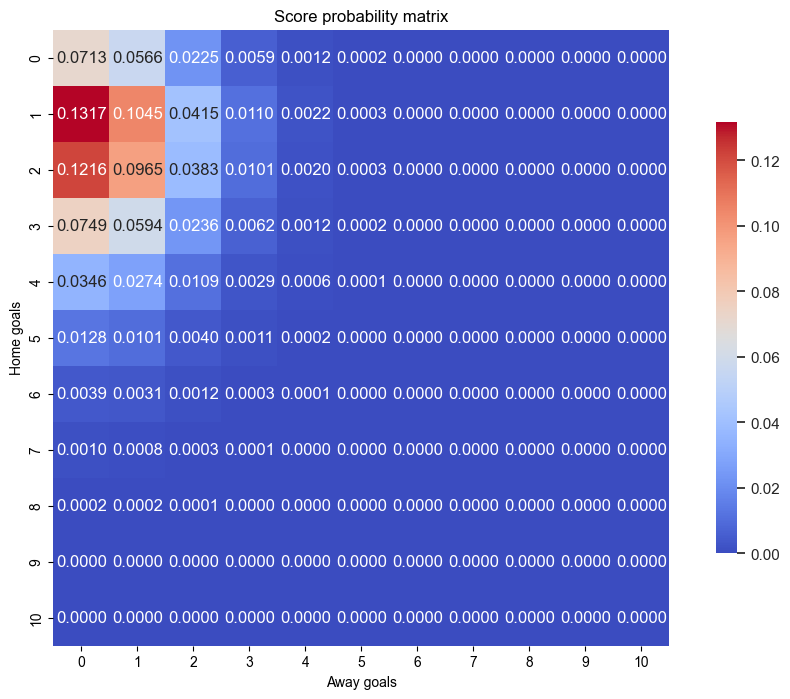

In [10]:
import numpy as np
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

home_expectancy = Home_expected_xg
away_expectancy = Away_expected_xg


max_score = 10
score_range = np.arange(0, max_score+1)

home_pmf = poisson.pmf(score_range, home_expectancy)
away_pmf = poisson.pmf(score_range, away_expectancy)

# calculate the outer product of the home and away PMFs
score_prob_matrix = np.outer(home_pmf, away_pmf)

# reshape the matrix into a square matrix of score probabilities
score_prob_matrix = score_prob_matrix.reshape(max_score+1, max_score+1)


# set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# create a heatmap using seaborn
sns.set()
sns.heatmap(score_prob_matrix, cmap="coolwarm", annot=True, fmt=".4f", square=True, cbar_kws={"shrink": 0.7}, ax=ax)

# set the axis labels and title
plt.xlabel("Away goals")
plt.ylabel("Home goals")
plt.title("Score probability matrix")

# display the plot
plt.show()

## Расчет вероятности Победы, Ничьи и Поражения (3 исхода)

Создаем таблицу для расчета вероятности исхода Матча на основе вероятностей счета в матче

In [11]:
# calculate the sums of home wins, draws, and away wins
home_wins = np.sum(np.tril(score_prob_matrix, -1))
draws = np.sum(np.diag(score_prob_matrix))
away_wins = np.sum(np.triu(score_prob_matrix, 1))

# create a table to display the sums
table_data = {
    "Home wins": [home_wins],
    "Draws": [draws],
    "Away wins": [away_wins]
}
table = pd.DataFrame(table_data)

# display the table
print(table)

   Home wins     Draws  Away wins
0   0.623507  0.220996   0.155493


## Уточненная матрица исходов

Предыдущая матрица имела погрешность в виде того, что сумма всех исходов не равнялась 1.0
Дополним отдельным расчетом по вероятности забить 0 голов для каждой команды и нормализуем значения матрицы

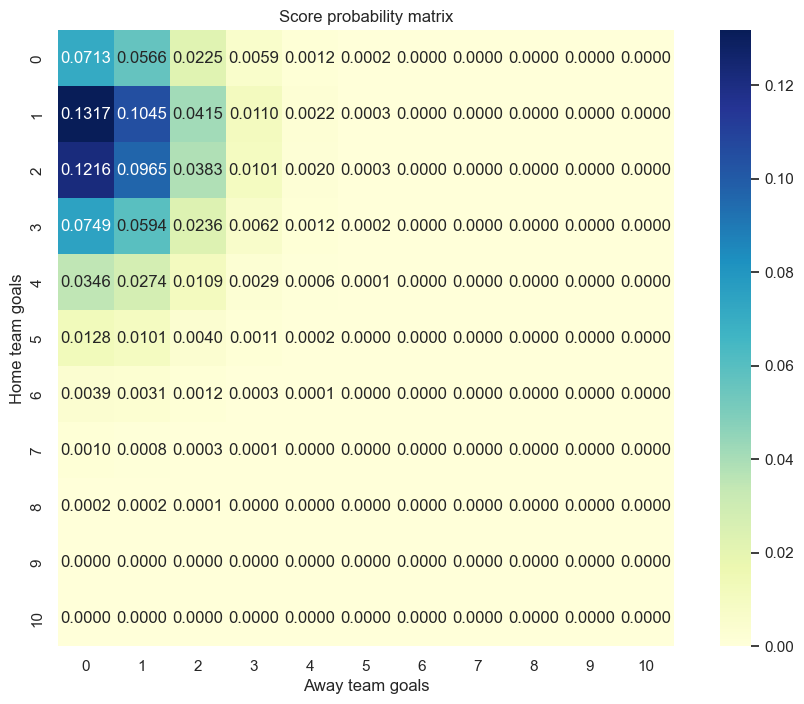

In [12]:
home_expectancy = Home_expected_xg
away_expectancy = Away_expected_xg

max_score = 10
score_range = np.arange(0, max_score+1)

# Calculate the probabilities of scoring zero goals using the Poisson distribution with a lambda of zero
home_zero_pmf = poisson.pmf(0, home_expectancy)
away_zero_pmf = poisson.pmf(0, away_expectancy)

# Calculate the probabilities of scoring non-zero goals using the Poisson distribution with lambda equal to the expectancies
home_nonzero_pmf = poisson.pmf(score_range, home_expectancy)
away_nonzero_pmf = poisson.pmf(score_range, away_expectancy)

# Combine the probabilities of zero and non-zero goals using the zero-inflated Poisson distribution
home_pmf = (1 - home_zero_pmf) * home_nonzero_pmf
away_pmf = (1 - away_zero_pmf) * away_nonzero_pmf

# Normalize the score probabilities to sum to 1.0 over the truncated range
score_prob_matrix /= score_prob_matrix.sum()

# set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Display the score probability matrix as a heatmap
sns.heatmap(score_prob_matrix, cmap="YlGnBu", annot=True, fmt=".4f", square=True, xticklabels=score_range, yticklabels=score_range)

plt.xlabel("Away team goals")
plt.ylabel("Home team goals")
plt.title("Score probability matrix")

plt.show()

## Уточненный расчет вероятности исхода матча

In [13]:
# calculate the sums of home wins, draws, and away wins
home_wins = np.sum(np.tril(score_prob_matrix, -1))
draws = np.sum(np.diag(score_prob_matrix))
away_wins = np.sum(np.triu(score_prob_matrix, 1))

# create a table to display the sums
table_data = {
    "Home wins": [1/home_wins],
    "Draws": [1/draws],
    "Away wins": [1/away_wins]
}
table = pd.DataFrame(table_data)

# display the table
print(table)

   Home wins     Draws  Away wins
0   1.603825  4.524942   6.431143
